# Supplementary Analyses
```
By: Jake M. Parelman
Final Edit: 06/30/2021
```

In [1]:
import numpy as np
import pandas as pd
import os, sys, glob
import re
import random 

from joblib import Parallel, delayed

from nilearn import image, plotting, masking,input_data,datasets
from nilearn.glm.second_level import SecondLevelModel
from nistats.thresholding import map_threshold
from scipy.stats import pearsonr

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import auc, plot_roc_curve, make_scorer, accuracy_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn import preprocessing



/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  # This is added back by InteractiveShellApp.init_path()


### S1: Univariate Contrast

In [15]:
# Load masks
WB_masker = image.load_img('../Data/ROI/wb_resampled.nii')
MPFC_masker = image.load_img('../Data/ROI/mPFC_resampled.nii')

# load first level maps Self > Other contrasts
P1 = image.load_img('../Data/P1_firstLevel_zmaps.nii')
CY = image.load_img('../Data/cy_firstLevel_zmaps.nii')
PA1 = image.load_img('../Data/pa1_firstLevel_zmaps.nii')

# Run second level model
design_matrix = pd.DataFrame([1] * len(all_subs), columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=1,mask_img=MPFC_masker)
second_level_model = second_level_model.fit(all_subs,
                                            design_matrix=design_matrix)

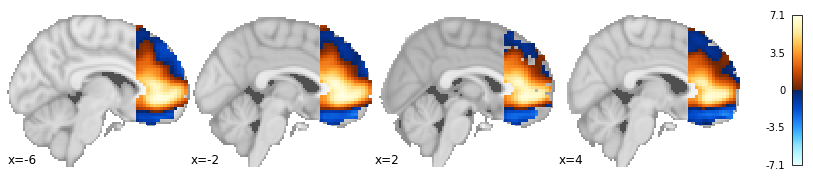

In [59]:
z_map_mpfc = second_level_model.compute_contrast(output_type='z_score')
im1 = plotting.plot_stat_map(z_map_mpfc,cmap='cyan_orange',
                       draw_cross=False,
                       black_bg=False,
                       display_mode='x',
                      cut_coords=[-6,-2,2,4])


In [18]:
def get_std_coords(vals,coefs):
    mpfc_x_coords = vals[0]
    nmin = np.min(mpfc_x_coords)
    nmax = np.max(mpfc_x_coords)
    std_x_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_x_coords]

    mpfc_y_coords = vals[1]
    nmin = np.min(mpfc_y_coords)
    nmax = np.max(mpfc_y_coords)
    std_y_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_y_coords]
    
    mpfc_z_coords = vals[2]
    nmin = np.min(mpfc_z_coords)
    nmax = np.max(mpfc_z_coords)
    std_z_coords = [((val - nmin)/(nmax - nmin)) for val in mpfc_z_coords]

    return pd.DataFrame({
        "Weight":coefs,
        "x":std_x_coords,
        "y":std_y_coords,
        "z":std_z_coords
    })

In [20]:
# Mask z-map from MPFC
mpfc_mask = input_data.NiftiMasker(mask_img=MPFC_masker)
z_coefs = mpfc_mask.fit_transform(z_map_mpfc)[0]
z_3d = np.array(np.where(z_map_mpfc.get_data() != 0))
z_df = get_std_coords(z_3d,z_coefs)

# load in ridge voxel weights
ridge_df = pd.read_csv('../Data/mpfc_weights_RidgePCA_xyz.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


#### Correlation between MPFC Ridge-PCA organization and z-map contrast

In [21]:
pearsonr(z_df.Weight,ridge_df.Weight)

(0.5153564657910926, 3.168699444534549e-243)

#### Comparing reliable regions with z-map

In [41]:
threshed_ridge = image.load_img('../Data/MPFC_Ridge_threshed.nii')
thresh_mask = input_data.NiftiMasker(masking.compute_background_mask(threshed_ridge))
z_vals = thresh_mask.fit_transform(z_map_mpfc)
ridge_vals = thresh_mask.fit_transform(threshed_ridge)

r = list(np.sign(z_vals)[0])
c = list(np.sign(ridge_vals)[0])
print(f"{np.round((sum([1 if r[_] == c[_] else 0 for _ in range(len(r))])/len(r)) * 100)}% directional overlap")

98.0% directional overlap


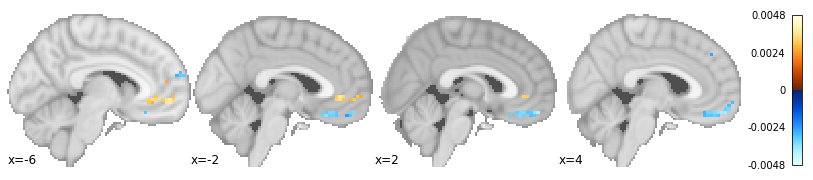

In [60]:
im1 = plotting.plot_stat_map(threshed_ridge,cmap='cyan_orange',
                       draw_cross=False,
                       black_bg=False,
                       display_mode='x',
                      cut_coords=[-6,-2,2,4])

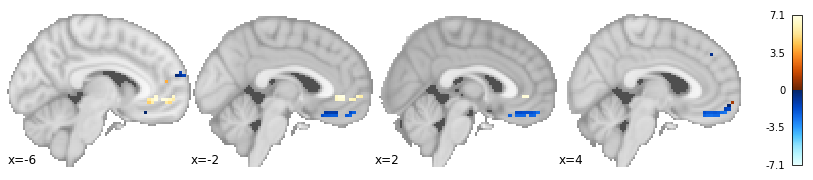

In [66]:
im1 = plotting.plot_stat_map(thresh_mask.inverse_transform(z_vals),cmap='cyan_orange',
                       draw_cross=False,
                       black_bg=False,
                       display_mode='x',
                      cut_coords=[-6,-2,2,4])

________

## PLS-DA

In [90]:
# Load in data
X_train = np.load('../Data/mpfc_training_X.npy')
y_train = np.load('../Data/mpfc_training_y.npy')

X_test = np.load('../Data/mpfc_testing_X.npy')
y_test = np.load('../Data/mpfc_testing_y.npy')

In [47]:
# stratified K-fold
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=5)

# scale training X
X_train = scale(X_train)
X_test = scale(X_test)

In [49]:
# training
CV_vals = []

# Already tested 1 - 1000, get a plateau in mean accuracy after 100
for n in [2,3,4,5,10,20]:
    # PLS with N components
    pls = PLSRegression(n_components=n,scale=False)
    acc = []
    # K-fold training, validating
    for train,validate in skfold.split(X=X_train,y=y_train):
        
        # set up dummy variable for Y
        train_X = X_train[train,:]
        train_y = [[1,0] if i == 1 else [0,1] for i in y_train[train]]

        test_X = X_train[validate,:]
        test_y = y_train[validate]
        
        # train model
        trained = pls.fit_transform(train_X,train_y)

        # predict validation values
        predicted = pls.predict(test_X)
        predicted = [1 if _[0] > _[1] else 0 for _ in predicted]
        
        accuracy = sum([1 if predicted[i] == test_y[i] else 0 for i in range(len(predicted))])/len(predicted)
        acc.append(accuracy)
        
    # CV mean and STD
    CV_vals.append({'n_components':n,'mean_accuracy':np.mean(acc)})
    print({'n_components':n,'mean_accuracy':np.mean(acc),'min':min(acc),'max':max(acc),'sd_accuracy':np.std(acc)})


# Retrain with best n-components on all training
trained_PLS = PLSRegression(n_components=4,scale=False)
trained_PLS.fit(X_train,[[1,0] if i == 1 else [0,1] for i in y_train])

{'n_components': 2, 'mean_accuracy': 0.5982532751091703, 'min': 0.537117903930131, 'max': 0.6375545851528385, 'sd_accuracy': 0.03983145589865985}
{'n_components': 3, 'mean_accuracy': 0.622707423580786, 'min': 0.5720524017467249, 'max': 0.6986899563318777, 'sd_accuracy': 0.04659206521694022}
{'n_components': 4, 'mean_accuracy': 0.6436681222707423, 'min': 0.5720524017467249, 'max': 0.6986899563318777, 'sd_accuracy': 0.04372049261409196}
{'n_components': 5, 'mean_accuracy': 0.6375545851528385, 'min': 0.5545851528384279, 'max': 0.6986899563318777, 'sd_accuracy': 0.05085039870047035}
{'n_components': 10, 'mean_accuracy': 0.622707423580786, 'min': 0.5807860262008734, 'max': 0.6593886462882096, 'sd_accuracy': 0.0300771621968953}
{'n_components': 20, 'mean_accuracy': 0.5633187772925764, 'min': 0.5152838427947598, 'max': 0.5895196506550219, 'sd_accuracy': 0.02856843184942556}


PLSRegression(copy=True, max_iter=500, n_components=5, scale=False, tol=1e-06)

In [54]:
T = 500
boots = []
for i in range(T):
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # predict
    test_predicted = trained_PLS.predict(X)
    test_predicted = [1 if _[0] > _[1] else 0 for _ in test_predicted]
    accuracy = sum([1 if test_predicted[i] == y[i] else 0 for i in range(len(test_predicted))])/len(test_predicted)
    boots.append(accuracy)
        
print(f'Mean = {np.mean(boots)}, CI = [{np.mean(boots) - (1.96*(np.std(boots)))}, {np.mean(boots) + (1.96*(np.std(boots)))}]')

Mean = 0.6059933333333334, CI = [0.5514436400096614, 0.6605430266570054]


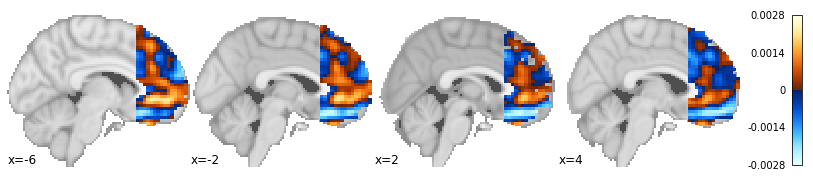

In [58]:
weights = [i[0] for i in trained_PLS.coef_]

mpfc_mask = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

threshed_map = mpfc_masker.inverse_transform(weights)
plotting.view_img(threshed_map)

im1 = plotting.plot_stat_map(threshed_map,cmap='cyan_orange',
                       draw_cross=False,
                       black_bg=False,
                       display_mode='x',
                      cut_coords=[-6,-2,2,4])

#### Whole Brain

In [105]:
# Load in data
X_train = np.load('../Data/wb_training_X.npy')
y_train = np.load('../Data/wb_training_y.npy')

X_test = np.load('../Data/wb_testing_X.npy')
y_test = np.load('../Data/wb_testing_y.npy')

In [106]:
# stratified K-fold
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=5)

# scale training X
X_train = scale(X_train)
X_test = scale(X_test)

In [107]:
# training
CV_vals = []

# Already tested 1 - 1000, get a plateau in mean accuracy after 100
for n in [2,3,4,5,10,20]:
    # PLS with N components
    pls = PLSRegression(n_components=n,scale=False)
    acc = []
    # K-fold training, validating
    for train,validate in skfold.split(X=X_train,y=y_train):
        
        # set up dummy variable for Y
        train_X = X_train[train,:]
        train_y = [[1,0] if i == 1 else [0,1] for i in y_train[train]]

        test_X = X_train[validate,:]
        test_y = y_train[validate]
        
        # train model
        trained = pls.fit_transform(train_X,train_y)

        # predict validation values
        predicted = pls.predict(test_X)
        predicted = [1 if _[0] > _[1] else 0 for _ in predicted]
        
        accuracy = sum([1 if predicted[i] == test_y[i] else 0 for i in range(len(predicted))])/len(predicted)
        acc.append(accuracy)
        
    # CV mean and STD
    CV_vals.append({'n_components':n,'mean_accuracy':np.mean(acc)})
    print({'n_components':n,'mean_accuracy':np.mean(acc),'min':min(acc),'max':max(acc),'sd_accuracy':np.std(acc)})


# Retrain with best n-components on all training
trained_PLS = PLSRegression(n_components=5,scale=False)
trained_PLS.fit(X_train,[[1,0] if i == 1 else [0,1] for i in y_train])

{'n_components': 2, 'mean_accuracy': 0.6471615720524018, 'min': 0.6157205240174672, 'max': 0.6768558951965066, 'sd_accuracy': 0.025522513879829626}
{'n_components': 3, 'mean_accuracy': 0.6829694323144104, 'min': 0.6157205240174672, 'max': 0.7205240174672489, 'sd_accuracy': 0.03998436032230428}
{'n_components': 4, 'mean_accuracy': 0.7004366812227074, 'min': 0.6637554585152838, 'max': 0.7379912663755459, 'sd_accuracy': 0.025100625088558818}
{'n_components': 5, 'mean_accuracy': 0.7109170305676857, 'min': 0.6899563318777293, 'max': 0.74235807860262, 'sd_accuracy': 0.018608974456473793}
{'n_components': 10, 'mean_accuracy': 0.6812227074235808, 'min': 0.6506550218340611, 'max': 0.7205240174672489, 'sd_accuracy': 0.02706014565035752}
{'n_components': 20, 'mean_accuracy': 0.6864628820960699, 'min': 0.6462882096069869, 'max': 0.7161572052401747, 'sd_accuracy': 0.02581964279317815}


PLSRegression(copy=True, max_iter=500, n_components=5, scale=False, tol=1e-06)

In [109]:
T = 500
boots = []
for i in range(T):
    if i % 25 == 0:
        print('*',end='')
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # predict
    test_predicted = trained_PLS.predict(X)
    test_predicted = [1 if _[0] > _[1] else 0 for _ in test_predicted]
    accuracy = sum([1 if test_predicted[i] == y[i] else 0 for i in range(len(test_predicted))])/len(test_predicted)
    boots.append(accuracy)
        
print(f'Mean = {np.mean(boots)}, CI = [{np.mean(boots) - (1.96*(np.std(boots)))}, {np.mean(boots) + (1.96*(np.std(boots)))}]')

********************Mean = 0.6936733333333334, CI = [0.6420361894247089, 0.7453104772419579]


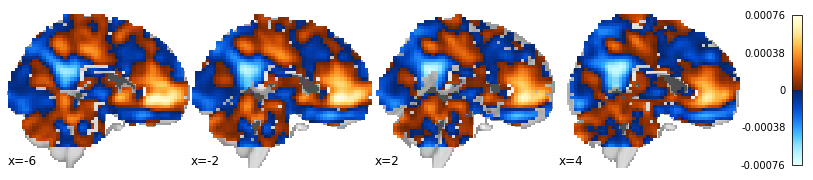

In [110]:
weights = [i[0] for i in trained_PLS.coef_]

mpfc_mask = image.load_img('../Data/ROI/wb_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

threshed_map = mpfc_masker.inverse_transform(weights)
plotting.view_img(threshed_map)

im1 = plotting.plot_stat_map(threshed_map,cmap='cyan_orange',
                       draw_cross=False,
                       black_bg=False,
                       display_mode='x',
                      cut_coords=[-6,-2,2,4])

______

### MPFC Sub-Region Analysis

In [30]:
# Load in data
X_train = np.load('../Data/mpfc_training_X.npy')
y_train = np.load('../Data/mpfc_training_y.npy')

X_test = np.load('../Data/mpfc_testing_X.npy')
y_test = np.load('../Data/mpfc_testing_y.npy')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() beha

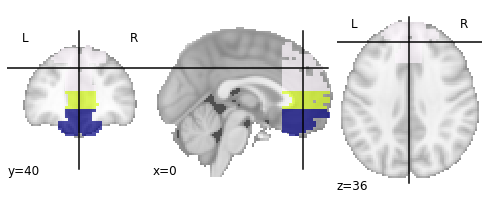

In [31]:
# Make three part split mask object for MPFC

MPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(MPFC)
mpfc_masker.fit_transform(MPFC)

VMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Vmpfc_data = VMPFC.get_data()
Vmpfc_data[:,:,-30:] = 0
Vmpfc_data[np.where(Vmpfc_data != 0)] = 1

MMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Mmpfc_data = MMPFC.get_data()
Mmpfc_data[:,:,:-30] = 0
Mmpfc_data[:,:,22:] = 0
Mmpfc_data[np.where(Mmpfc_data != 0)] = 2

DMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Dmpfc_data = DMPFC.get_data()
Dmpfc_data[:,:,:22] = 0
Dmpfc_data[np.where(Dmpfc_data != 0)] = 3

ROIs = Vmpfc_data + Mmpfc_data + Dmpfc_data

tripartite = image.new_img_like(DMPFC,ROIs)
MPFC_ROI_mask = input_data.NiftiLabelsMasker(tripartite)

plotting.plot_roi(tripartite)

In [32]:
# Get Average data from Three ROI
X_train = MPFC_ROI_mask.fit_transform(mpfc_masker.inverse_transform(X_train))
X_test = MPFC_ROI_mask.fit_transform(mpfc_masker.inverse_transform(X_test))

scoring = {'Accuracy': make_scorer(accuracy_score)}
# Model Training 
regression_ = GridSearchCV(estimator=LogisticRegression(penalty='none'),
                     cv=skfold,
                     scoring=scoring,
                     n_jobs=1,
                     param_grid=dict(C=[0]),
                               return_train_score=False,
                           refit='Accuracy')

# Tuning
regression_.fit(X_train,y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWar

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=1, param_grid={'C': [0]},
             pre_dispatch='2*n_jobs', refit='Accuracy',
             return_train_score=False,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=0)

In [33]:
CV_df = pd.DataFrame(regression_.cv_results_)
CV_df.loc[regression_.best_index_]
CV_df.loc[regression_.best_index_,]

mean_fit_time           0.005197
std_fit_time            0.001052
mean_score_time         0.000361
std_score_time          0.000017
param_C                        0
params                  {'C': 0}
split0_test_Accuracy    0.620087
split1_test_Accuracy    0.502183
split2_test_Accuracy    0.585153
split3_test_Accuracy    0.606987
split4_test_Accuracy    0.624454
mean_test_Accuracy      0.587773
std_test_Accuracy       0.044925
rank_test_Accuracy             1
Name: 0, dtype: object

In [95]:
# Functions for permutations

k = 1000

def permute(x,classifier):
    if x % 100 == 0:
        print("*",end="")
    yy = y_train.copy()
    np.random.shuffle(yy)    

    classifier.fit(X_train,yy)
    orig_features = classifier.coef_[0]
    return orig_features
    
def test_perms(x):
    """
    calculate p_value
    """
    perm_list = np.abs(x[:-1])
    model_val = np.abs(x[-1]) # last row is true model
    greater_equal = [i for i in perm_list if i >= model_val]
    return len(greater_equal)/len(perm_list)

# run permutations
ridge_perm_classifier = LogisticRegression(penalty='none')

# Run permutation
Perms = []
for x in range(k):
    Perms.append(permute(x, ridge_perm_classifier))

# last row true model
Perms.append(regression_.best_estimator_.coef_[0])

**********

In [96]:
weights = regression_.best_estimator_.coef_[0]

In [100]:
# permutation testing for significance of each ROI

v_p = 0
m_p = 0
d_p = 0
for p in Perms[:-1]:
    if abs(p[0]) >= abs(weights[0]):
        v_p += 1
    if abs(p[1] )>= abs(weights[1]):
        m_p += 1
    if abs(p[2]) >= abs(weights[2]):
        d_p += 1
        
print(v_p/1000)
print(m_p/1000)
print(d_p/1000)

MPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(MPFC)
mpfc_masker.fit_transform(MPFC)

VMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Vmpfc_data = VMPFC.get_data()
Vmpfc_data[:,:,-30:] = 0
Vmpfc_data[np.where(Vmpfc_data != 0)] = weights[0]

MMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Mmpfc_data = MMPFC.get_data()
Mmpfc_data[:,:,:-30] = 0
Mmpfc_data[:,:,22:] = 0
Mmpfc_data[np.where(Mmpfc_data != 0)] = weights[1]

DMPFC = image.load_img('../Data/ROI/mPFC_resampled.nii')
Dmpfc_data = DMPFC.get_data()
Dmpfc_data[:,:,:22] = 0
Dmpfc_data[np.where(Dmpfc_data != 0)] = weights[2]

values = Vmpfc_data + Mmpfc_data + Dmpfc_data

0.321
0.0
0.0


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, 

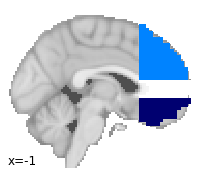

In [101]:
plotting.plot_stat_map(image.new_img_like(MPFC,values),draw_cross=False,colorbar=False,display_mode='x',cut_coords=[-1])

In [104]:
T = 500
boots = []


for i in range(T):
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # Test Accuracy
    accuracy = np.sum(y == regression_.predict(X))/len(y) 
    boots.append(accuracy)
lower = np.mean(boots) - (1.96 * np.std(boots))
upper = np.mean(boots) + (1.96 * np.std(boots))
acc = np.round(np.mean(boots) *100,2)
print(f"Test Accuracy = {acc}, [{lower},{upper}], std = {np.std(boots)}")

Test Accuracy = 51.78, [0.46176740331453214,0.5737925966854679], std = 0.028577855451769333


______

## SVC models

In [34]:
X_train = np.load('../Data/mpfc_training_X.npy')
y_train = np.load('../Data/mpfc_training_y.npy')

X_test = np.load('../Data/mpfc_testing_X.npy')
y_test = np.load('../Data/mpfc_testing_y.npy')

# Scale data
X_train_mc = preprocessing.StandardScaler().fit_transform(X_train)
X_test_mc = preprocessing.StandardScaler().fit_transform(X_test)

mpfc_pca = PCA()
# Fit PCA
X_train = mpfc_pca.fit_transform(X_train)
X_test = mpfc_pca.transform(X_test)

In [35]:
#SVN setup
svm = SVC(kernel='linear')

svm_ = GridSearchCV(estimator=svm,
                             cv=skfold,
                             scoring=scoring,
                             refit = 'Accuracy',
                             n_jobs=1,
                             verbose=1,
                             param_grid=dict(C=np.arange(0.001,1,0.1)),
                                       return_train_score=True)


# Tuning
svm_.fit(X_train,y_train)
svm_hyper = svm_.best_params_['C']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


In [36]:

CV_df = pd.DataFrame(svm_.cv_results_)
CV_df.loc[svm_.best_index_]

mean_fit_time                0.998429
std_fit_time                 0.026569
mean_score_time              0.203379
std_score_time               0.002595
param_C                         0.001
params                   {'C': 0.001}
split0_test_Accuracy         0.646288
split1_test_Accuracy         0.585153
split2_test_Accuracy         0.598253
split3_test_Accuracy         0.620087
split4_test_Accuracy         0.611354
mean_test_Accuracy           0.612227
std_test_Accuracy            0.020741
rank_test_Accuracy                  1
split0_train_Accuracy        0.829694
split1_train_Accuracy        0.847162
split2_train_Accuracy         0.83952
split3_train_Accuracy        0.825328
split4_train_Accuracy        0.830786
mean_train_Accuracy          0.834498
std_train_Accuracy            0.00783
Name: 0, dtype: object

In [125]:
T = 500
boots = []

for i in range(T):
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # Test Accuracy
    accuracy = np.sum(y == svm_.predict(X))/len(y) 
    boots.append(accuracy)

        
print(f'Mean = {np.mean(boots)}, CI = [{np.mean(boots) - (1.96*(np.std(boots)))}, {np.mean(boots) + (1.96*(np.std(boots)))}]')

Mean = 0.5994866666666667, CI = [0.5399786923910941, 0.6589946409422394]


#### Whole Brain SVC

In [37]:
X_train = np.load('../Data/wb_training_X.npy')
y_train = np.load('../Data/wb_training_y.npy')

X_test = np.load('../Data/wb_testing_X.npy')
y_test = np.load('../Data/wb_testing_y.npy')

# Scale data
X_train_mc = preprocessing.StandardScaler().fit_transform(X_train)
X_test_mc = preprocessing.StandardScaler().fit_transform(X_test)

# Fit PCA
X_train = mpfc_pca.fit_transform(X_train)
X_test = mpfc_pca.transform(X_test)

In [38]:
#SVN setup
svm = SVC(kernel='linear')

svm_ = GridSearchCV(estimator=svm,
                             cv=skfold,
                             scoring=scoring,
                             refit = 'Accuracy',
                             n_jobs=1,
                             verbose=1,
                             param_grid=dict(C=np.arange(0.001,1,0.1)),
                                       return_train_score=True)


# Tuning
svm_.fit(X_train,y_train)
svm_hyper = svm_.best_params_['C']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


In [39]:

CV_df = pd.DataFrame(svm_.cv_results_)
CV_df.loc[svm_.best_index_]

mean_fit_time                1.100377
std_fit_time                 0.019834
mean_score_time              0.190818
std_score_time               0.004536
param_C                         0.001
params                   {'C': 0.001}
split0_test_Accuracy         0.729258
split1_test_Accuracy          0.68559
split2_test_Accuracy         0.676856
split3_test_Accuracy         0.703057
split4_test_Accuracy         0.707424
mean_test_Accuracy           0.700437
std_test_Accuracy            0.018236
rank_test_Accuracy                  1
split0_train_Accuracy             1.0
split1_train_Accuracy             1.0
split2_train_Accuracy             1.0
split3_train_Accuracy             1.0
split4_train_Accuracy             1.0
mean_train_Accuracy               1.0
std_train_Accuracy                0.0
Name: 0, dtype: object

In [9]:
T = 500
boots = []

for i in range(T):
    # Bootstrap Sample
    ix,y = zip(*[random.choice(list(enumerate(y_test))) for i in range(len(y_test))])
    X = X_test[ix,:]

    # Test Accuracy
    accuracy = np.sum(y == svm_.predict(X))/len(y) 
    boots.append(accuracy)

        
print(f'Mean = {np.mean(boots)}, CI = [{np.mean(boots) - (1.96*(np.std(boots)))}, {np.mean(boots) + (1.96*(np.std(boots)))}]')

Mean = 0.6359066666666667, CI = [0.5805403705545613, 0.6912729627787721]


_______

## Training model on studies individually 

In [20]:
df = pd.read_csv('../Data/All_mpfc_data.csv')
df = df.drop(['Unnamed: 0','sub'],1)
df.study.value_counts()

PA1         707
cityyear    468
project1    270
Name: study, dtype: int64

In [21]:
s1_df = df.loc[df.study == 'PA1']
s2_df = df.loc[df.study == 'cityyear']
s3_df = df.loc[df.study == 'project1']

#### Study 1


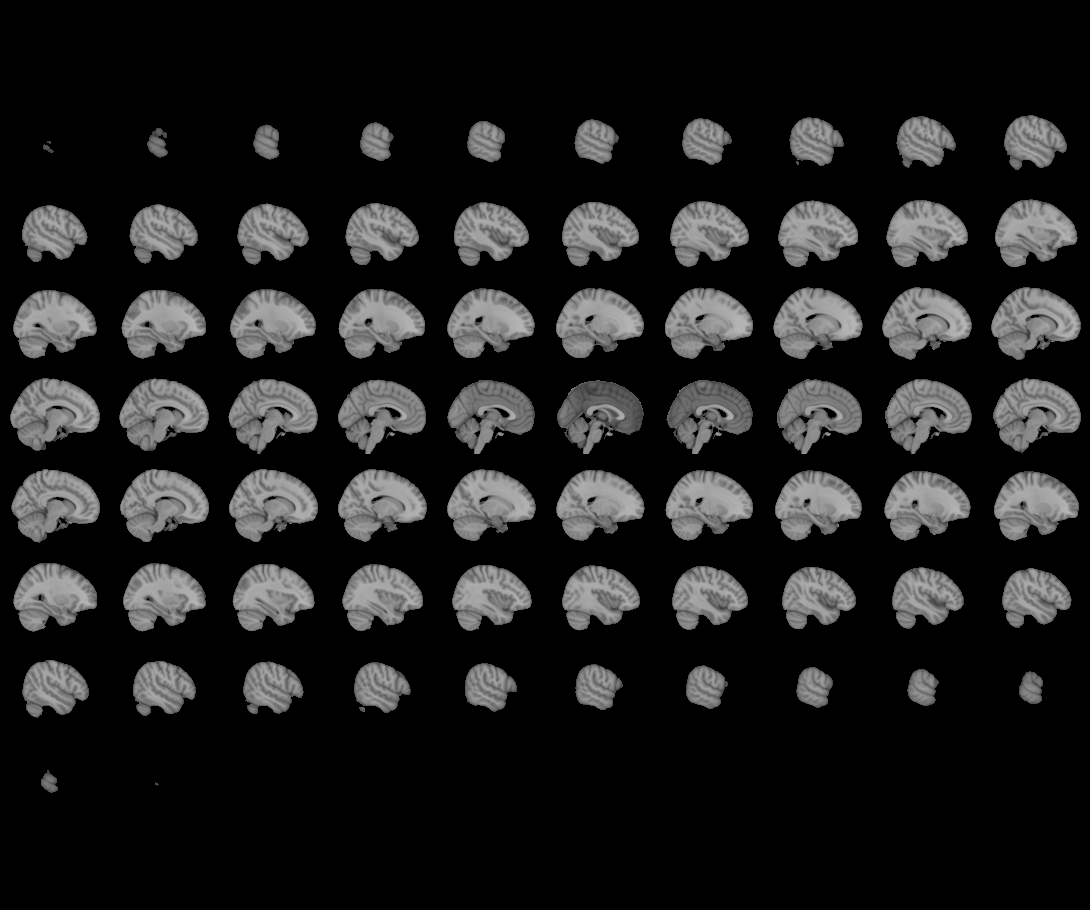
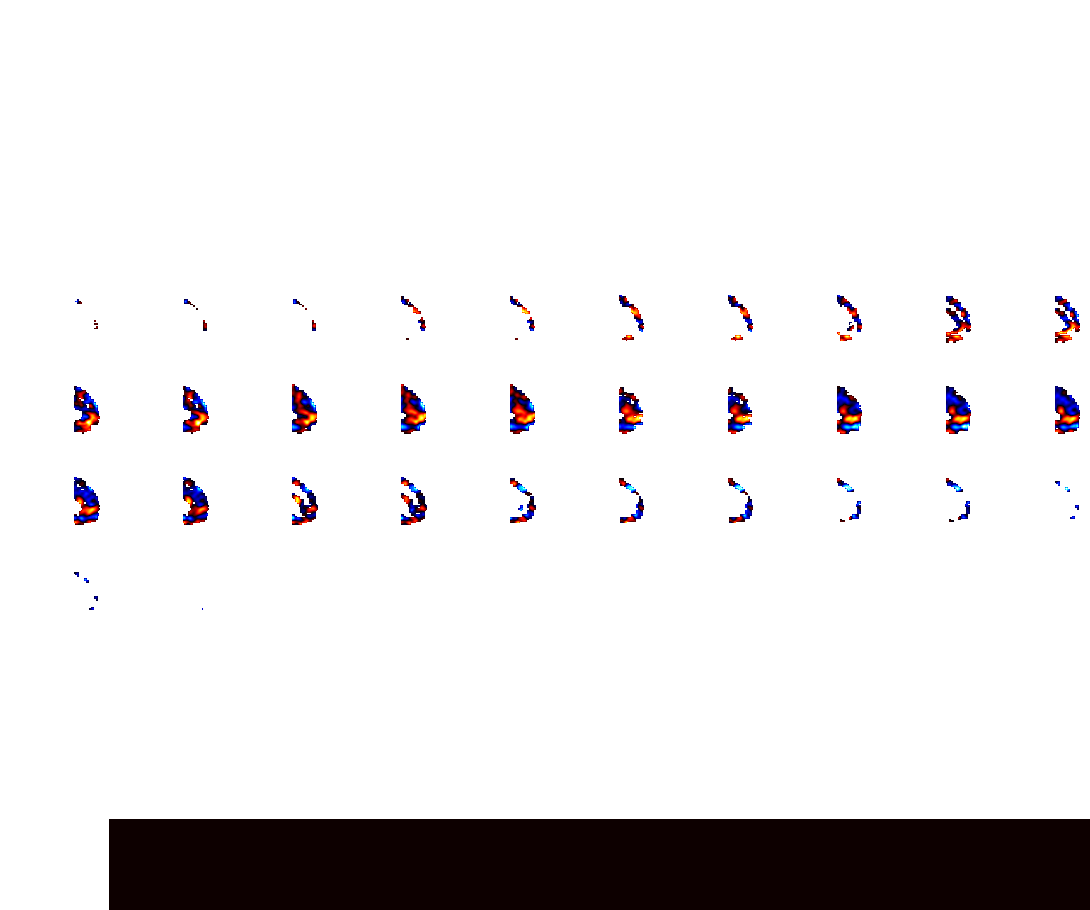

In [17]:
X = preprocessing.StandardScaler().fit_transform(s1_df.iloc[:,2:])
y = PA1_df.trial_type

mpfc_pca = PCA()
X = mpfc_pca.fit_transform(X)

# Ridge setup
ridge_ = GridSearchCV(estimator=LogisticRegression(penalty='l2',solver='liblinear'),
                     cv=skfold,
                     scoring=scoring,
                     n_jobs=1,
                     param_grid=dict(C=[0.0001]),
                               return_train_score=False,
                           refit='Accuracy')

# Tuning
ridge_.fit(X,y)

_map = np.dot(mpfc_pca.components_.T,ridge_.best_estimator_.coef_[0])



mpfc_mask = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

threshed_map = mpfc_masker.inverse_transform(_map)
plotting.view_img(threshed_map,black_bg=True,draw_cross=False)

#### Study 2


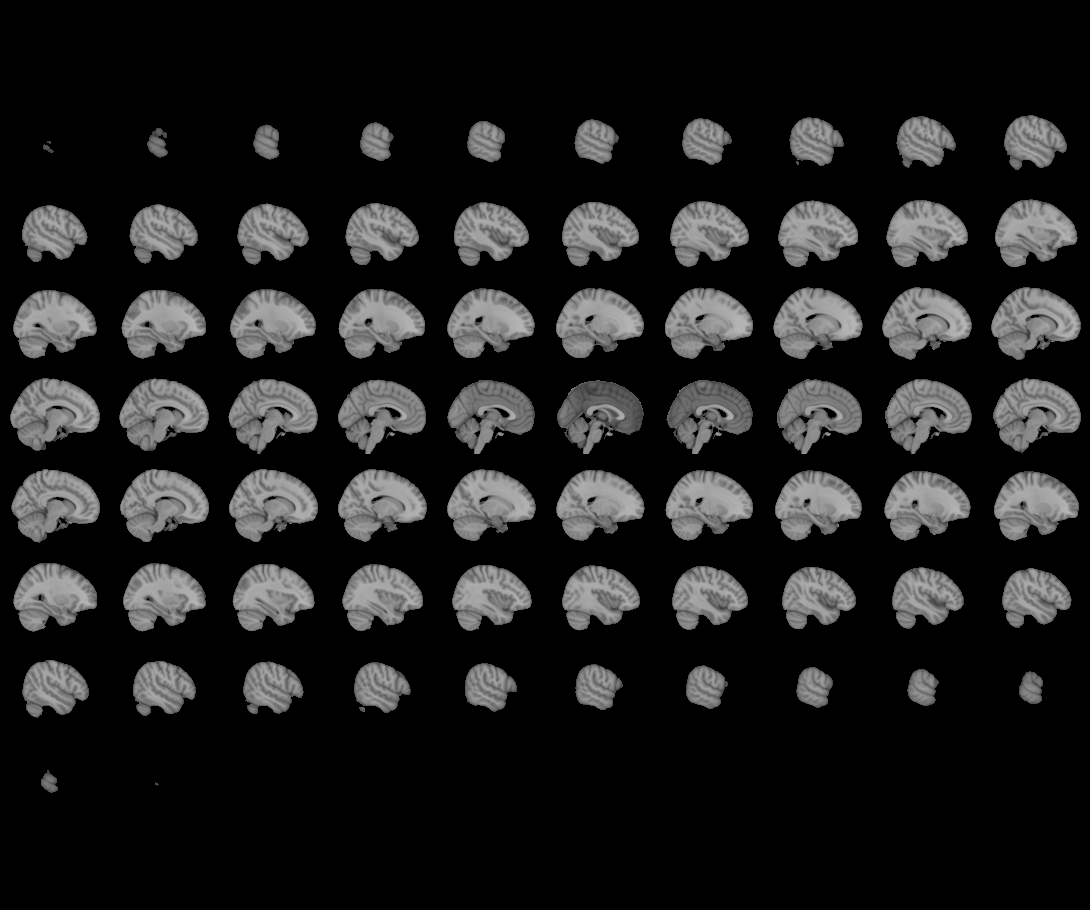
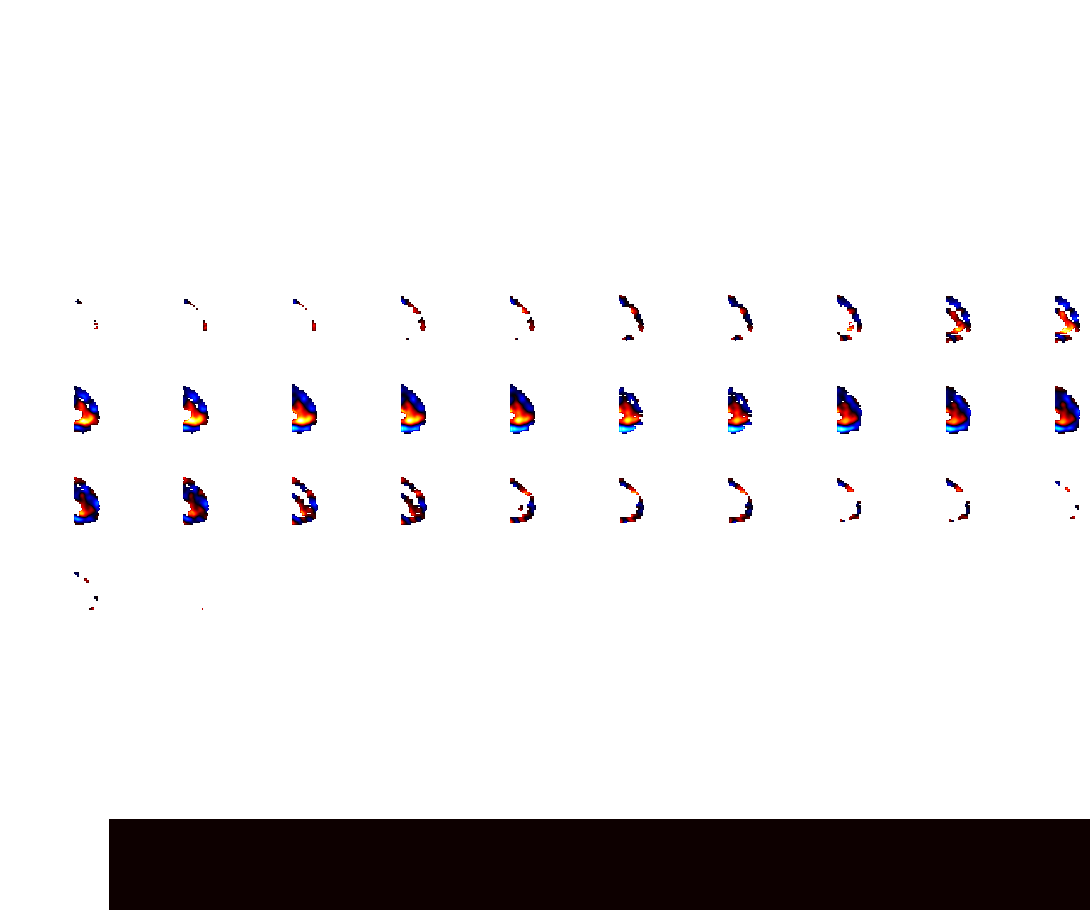

In [28]:
X = preprocessing.StandardScaler().fit_transform(s2_df.iloc[:,2:])
y = s2_df.trial_type

mpfc_pca = PCA()
X = mpfc_pca.fit_transform(X)

# Ridge setup
ridge_ = GridSearchCV(estimator=LogisticRegression(penalty='l2',solver='liblinear'),
                     cv=skfold,
                     scoring=scoring,
                     n_jobs=1,
                     param_grid=dict(C=[0.0001]),
                               return_train_score=False,
                           refit='Accuracy')

# Tuning
ridge_.fit(X,y)

_map = np.dot(mpfc_pca.components_.T,ridge_.best_estimator_.coef_[0])



mpfc_mask = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

threshed_map = mpfc_masker.inverse_transform(_map)
plotting.view_img(threshed_map,black_bg=True,draw_cross=False)

#### Study 3


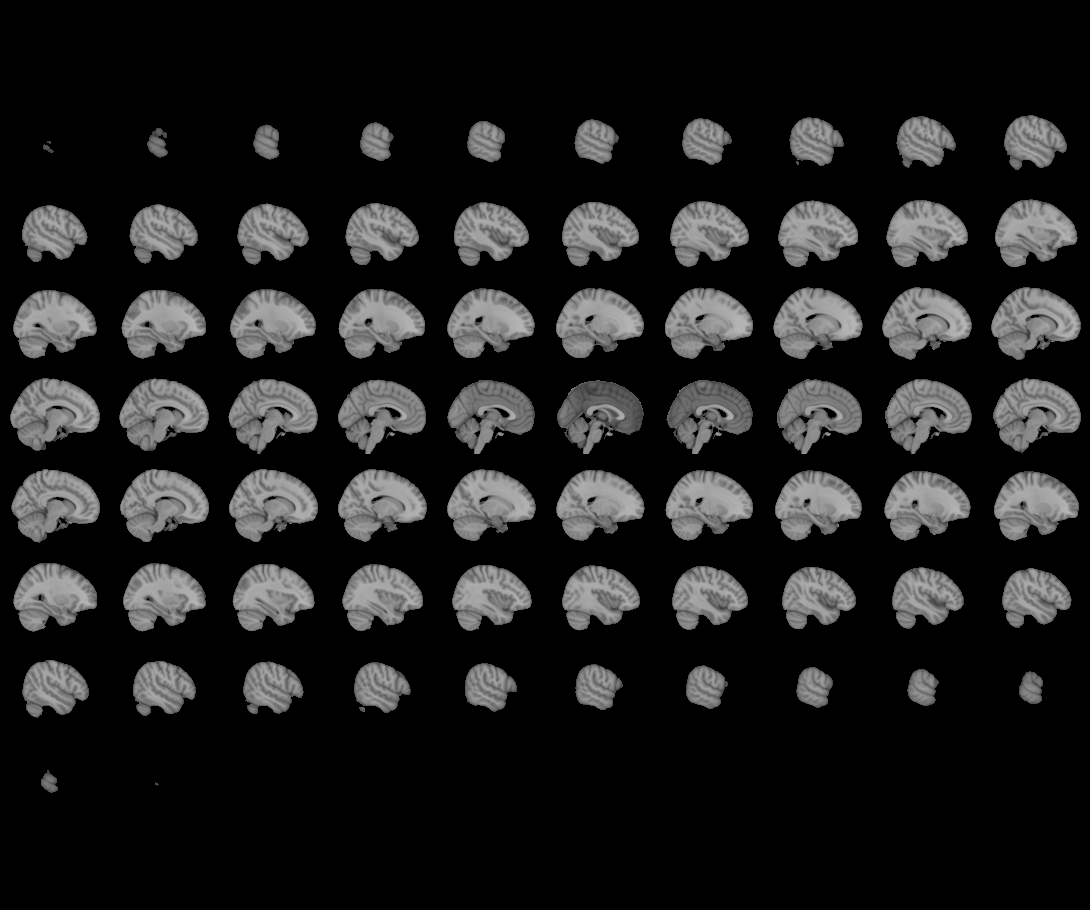
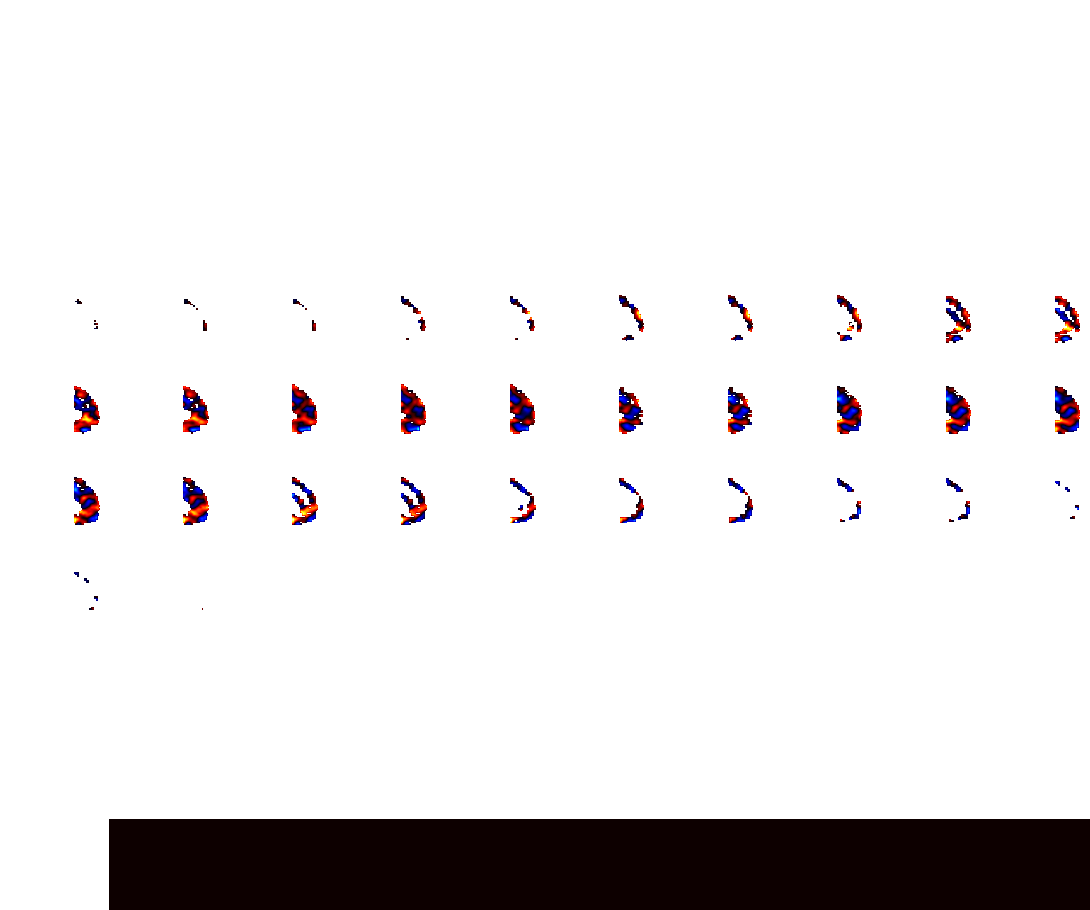

In [29]:
X = preprocessing.StandardScaler().fit_transform(s3_df.iloc[:,2:])
y = s3_df.trial_type

mpfc_pca = PCA()
X = mpfc_pca.fit_transform(X)

# Ridge setup
ridge_ = GridSearchCV(estimator=LogisticRegression(penalty='l2',solver='liblinear'),
                     cv=skfold,
                     scoring=scoring,
                     n_jobs=1,
                     param_grid=dict(C=[0.0001]),
                               return_train_score=False,
                           refit='Accuracy')

# Tuning
ridge_.fit(X,y)

_map = np.dot(mpfc_pca.components_.T,ridge_.best_estimator_.coef_[0])



mpfc_mask = image.load_img('../Data/ROI/mPFC_resampled.nii')
mpfc_masker = input_data.NiftiMasker(mask_img=mpfc_mask)
mpfc_masker.fit_transform(mpfc_mask)

threshed_map = mpfc_masker.inverse_transform(_map)
plotting.view_img(threshed_map,black_bg=True,draw_cross=False)